In [1]:
# import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted, natsort_keygen
from collections import Counter
from scipy.stats import chi2_contingency, spearmanr, rankdata, ttest_ind
import warnings
import re
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pandas.api.types import CategoricalDtype

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# data
DF = pd.read_csv('../Data/processed_data.csv')

## Reindex ordinal columns in the correct order

In [4]:
def natsort_reindex(df, lst_cols):
    
    ''' Reindex ordinal columns after human sorting them'''
    df_copy = df.copy()
    
    for col in lst_cols: 
        natsorted_idx = natsorted(df_copy[col].value_counts().index)
        df_copy[col] = pd.Categorical(df_copy[col],natsorted_idx)
    
    return df_copy

In [5]:
ordinal_columns_to_reindex = ['price','appraisal_offer','mileage','mileage_appraisal',
                  'engine','engine_appraisal']

df = natsort_reindex(DF, ordinal_columns_to_reindex)

## Correlation between ordinal variables

In [6]:
appraisal_ordinal_cols = ['appraisal_offer','model_year_appraisal','mileage_appraisal',
                          'engine_appraisal','cylinders_appraisal',
                          'mpg_city_appraisal','mpg_highway_appraisal',
                          'horsepower_appraisal','fuel_capacity_appraisal']

In [7]:
purchase_ordinal_cols =  ['price','model_year','mileage','engine','cylinders',
                          'mpg_city','mpg_highway','horsepower','fuel_capacity']

In [8]:
def spearmanR_heatmap(df, X_cols, Y_cols):
    outr_lst = []
    for col1 in Y_cols:
        innr_lst = []
        for col2 in X_cols:
            res = spearmanr(df[col1], df[col2])
            if res.pvalue<0.05:
                innr_lst.append(round(res.correlation,3))
            else:
                innr_lst.append(0)
        outr_lst.append(innr_lst)
    
    categorical_association_spearmanr = pd.DataFrame(outr_lst, index=Y_cols, columns=X_cols)
    
    fig, ax = plt.subplots(figsize=(8,6)) 
    sns.heatmap(categorical_association_spearmanr, annot=True, cmap='YlGnBu', 
                linewidth=0.05, linecolor='k', ax =ax)
    # plt.savefig('../plots/spearmanR_heatmap_appraisal_purchase_cols.png', bbox_inches = 'tight');
    return None

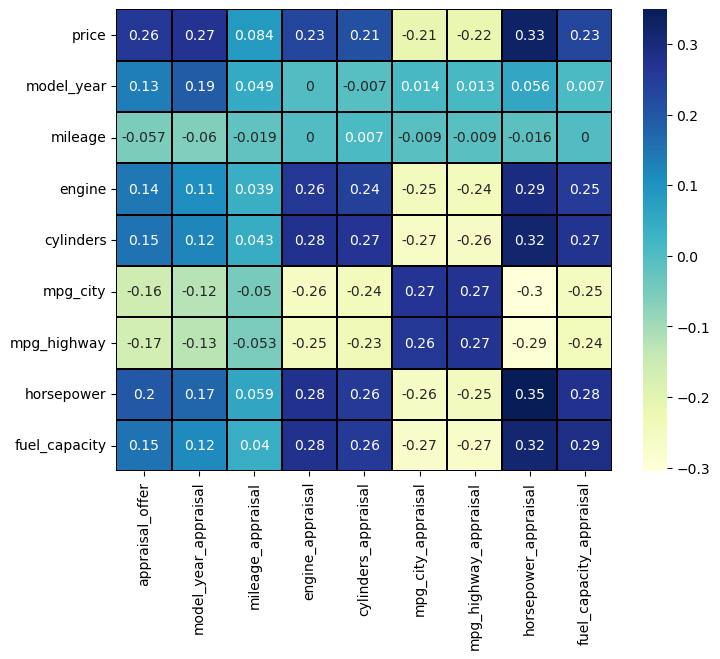

In [1476]:
spearmanR_heatmap(df, appraisal_ordinal_cols, purchase_ordinal_cols)

**key takeaways**
- Horsepower, fuel_capacity, engine and cylinders of the appraised car have a positive correlation with the horsepower, fuel_capacity, engine and cylinders of the purchased car. This means that customers who sell a car of certain performance buy back a similar car.

- They have a positive correlation with price and a negative correlation with mpg. This makes sense becuase as the performance of the car increases, it becomes more expensive and less fuel-efficient.

- appraisal_offer and model_year_appraisal have a positive correlation with price



In [1418]:
# correlation between appraisal_offer and model_year_appraisal?

spearmanr(df['appraisal_offer'], df['model_year_appraisal'])

SpearmanrResult(correlation=0.5097732072187744, pvalue=0.0)

In [1749]:
# correlation between appraisal_offer and horsepower?

spearmanr(df['appraisal_offer'], df['cylinders_appraisal'])

SpearmanrResult(correlation=0.022578008780416704, pvalue=6.968808332892659e-16)

In [1452]:
# correlation between model_year_appraisal and horsepower?

spearmanr(df['model_year_appraisal'], df['cylinders_appraisal'])

SpearmanrResult(correlation=-0.20194302522930602, pvalue=0.0)

In [1419]:
# correlation between appraisal car specs

appraisal_car_specs = ['engine_appraisal','cylinders_appraisal',
                       'mpg_city_appraisal','mpg_highway_appraisal',
                       'horsepower_appraisal','fuel_capacity_appraisal']

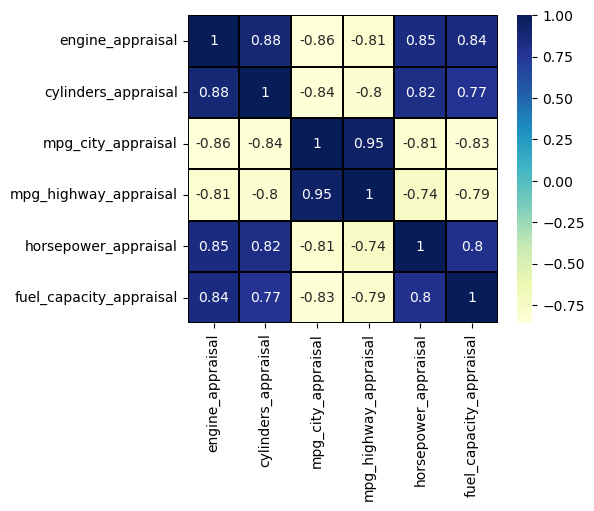

In [1474]:
spearmanR_heatmap(df, appraisal_car_specs, appraisal_car_specs)

Engine_appraisal, cylinders_appraisal, horsepower, fuel_capacity, mpg_city and mpg_highway are highly correlated. They cannot be used as part of a regression equation.

## Ordinal regression

In [1439]:
# make dependent variable categorical datatype

price_ordered_levels = CategoricalDtype(categories=['$0 to $15k',
 '$15k to $20k',
 '$20k to $25k',
 '$25k to $30k',
 '$30k to $35k',
 '$35k to $40k',
 '$40k to $45k',
 '$45k to $50k',
 '$50k to $55k',
 '$55k to $60k',
 '$60k to $65k',
 '$65k to $70k',
 '$70k+'], ordered=True)

df["price"] = df["price"].astype(price_ordered_levels)

In [1455]:
mod_log = OrderedModel.from_formula(formula='''price ~ C(appraisal_offer) + model_year_appraisal 
+cylinders_appraisal''', data = df, distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  price   Log-Likelihood:            -2.3675e+05
Model:                   OrderedModel   AIC:                         4.735e+05
Method:            Maximum Likelihood   BIC:                         4.738e+05
Date:                Thu, 05 Jan 2023                                         
Time:                        23:14:08                                         
No. Observations:              127758                                         
Df Residuals:                  127736                                         
Df Model:                          22                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
C(appraisal_offer)[T.$5k to $10k]      0.7737      0.016     47.490      0.000       0.742       0.806
C(appraisal_offer)[T.$10k to $15k]     1.1095      0.020     56.126      0.000       1.071       1.148
C(appraisal_offer)[T.$15k to $20k]     1.2440      0.023     54.977      0.000       1.200       1.288
C(appraisal_offer)[T.$20k to $25k]     1.4278      0.026     54.790      0.000       1.377       1.479
C(appraisal_offer)[T.$25k to $30k]     1.5735      0.031     50.449      0.000       1.512       1.635
C(appraisal_offer)[T.$30k to $35k]     1.6066      0.038     41.894      0.000       1.531       1.682
C(appraisal_offer)[T.$35k to $40k]     1.6107      0.047     34.238      0.000       1.519       1.703
C(appraisal_offer)[T.$40k+]            1.7580      0.050     34.868      0.000       1.659       1.857
model_year_appraisal                   0.0355      0.002     18.045      0.000       0.032       0.039
cylinders_appraisal                    0.3298      0.005     73.053      0.000       0.321       0.339
$0 to $15k/$15k to $20k               70.3156      3.956     17.774      0.000      62.562      78.069
$15k to $20k/$20k to $25k              0.7037      0.007    104.812      0.000       0.691       0.717
$20k to $25k/$25k to $30k              0.2499      0.005     48.478      0.000       0.240       0.260
$25k to $30k/$30k to $35k             -0.0279      0.006     -4.876      0.000      -0.039      -0.017
$30k to $35k/$35k to $40k             -0.1988      0.007    -27.841      0.000      -0.213      -0.185
$35k to $40k/$40k to $45k             -0.1338      0.009    -15.349      0.000      -0.151      -0.117
$40k to $45k/$45k to $50k             -0.1923      0.012    -15.603      0.000      -0.216      -0.168
$45k to $50k/$50k to $55k             -0.1689      0.017     -9.657      0.000      -0.203      -0.135
$50k to $55k/$55k to $60k             -0.3018      0.027    -11.187      0.000      -0.355      -0.249
$55k to $60k/$60k to $65k             -0.2527      0.038     -6.657      0.000      -0.327      -0.178
$60k to $65k/$65k to $70k             -0.4144      0.058     -7.096      0.000      -0.529      -0.300
$65k to $70k/$70k+                    -0.5007      0.083     -6.010      0.000      -0.664      -0.337
======================================================================================================
"""

The appraisal offer 0k to 5k is used as the reference group. With increase in appraisal_offer, the odds of the customer purchasing a car from a higher price range with respect to the reference group increases by a factor of 2.17 (for 5k to 10k) to 5.8 (for 40k+) 

One unit increase in cylinders_appraisal keeping all other variables constant increases the odds of buying a car from a higher price range by a factor of 1.39 ($e^{0.3298}$) or 39%

One unit increase in model_year_appraisal keeping all other variables constant increases the odds of buying a car from a higher price range by a factor of 1.04 ($e^{0.03555}$) or 4%

## Cardinality reduction

In [9]:
# Cardinality reduction
# Keep only the levels that contribute add up to 90% of total data

def cummulatively_categorise(df, column,threshold=0.9,return_categories_list=False):
    
    threshold_value=int(threshold*len(df[column]))
    categories_list=[]
    s=0
    counts=Counter(df[column])
    
    for i,j in counts.most_common():
        s+= counts[i]
        categories_list.append(i)
        if s>=threshold_value:
            break
    
    categories_list.append('Other')
    new_column= df[column].apply(lambda x: x if x in categories_list else 'Other')
    
    if(return_categories_list):
        return new_column,categories_list
    else:
        return new_column

In [10]:
reduce_cardinality_columns = ['make_appraisal','make','model_appraisal','model',
                             'color_appraisal','color']

In [11]:
for col in reduce_cardinality_columns:
    df[col] = cummulatively_categorise(df, col)

## Association between categorical variables

**What is Cramér's_V?** \
Cramér's_V is a measure of strength of association between two categorical variables. It ranges from 0 to 1. '0' indicates no association between the two variables and '1' indicates perfect association between two variables.

**Describing strength of association:** 
+ Less than + or - 0.10: very weak
+  \+ or -0.10 to 0.19: weak 
+  \+ or - 0.20 to 0.29: moderate 
+  \+ or - 0.30 or above: strong

In [24]:
# Calculating cramer's_V

def cramers_v_new(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2,p_val = chi2_contingency(confusion_matrix)[:2]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    minDim = min(confusion_matrix.shape)-1
    V = np.sqrt(phi2 / minDim)
    
    return V, p_val

In [686]:
# Calculating cramer's_V

# def cramers_v_old(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2,p_val = chi2_contingency(confusion_matrix)[:2]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
# 
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))), p_val

In [1265]:
appraisal_cols = ['appraisal_offer','make_appraisal',
                  'model_appraisal','trim_descrip_appraisal','body_appraisal','color_appraisal'
                  ,'market', 'online_appraisal_flag']

In [1791]:
purchase_cols = ['price','make','model','trim_descrip','body','color']

In [1789]:
def cramerV_heatmap(df, X_cols, Y_cols):
    outr_lst = []
    for col1 in Y_cols:
        innr_lst = []
        for col2 in X_cols:
            assc, p_val = cramers_v_new(df[col1], df[col2])
            if p_val<0.05:
                innr_lst.append(round(assc,3))
            else:
                innr_lst.append(0)
        outr_lst.append(innr_lst)
    
    categorical_association_cramerv = pd.DataFrame(outr_lst, index=Y_cols, columns=X_cols)
    
    fig, ax = plt.subplots(figsize=(6,4)) 
    sns.heatmap(categorical_association_cramerv, annot=True, cmap='YlGnBu', 
                linewidth=0.05, linecolor='k', ax =ax)
    # plt.savefig('../plots/cramersV_heatmap_reduced_cardinality.png', bbox_inches = 'tight');
    return None

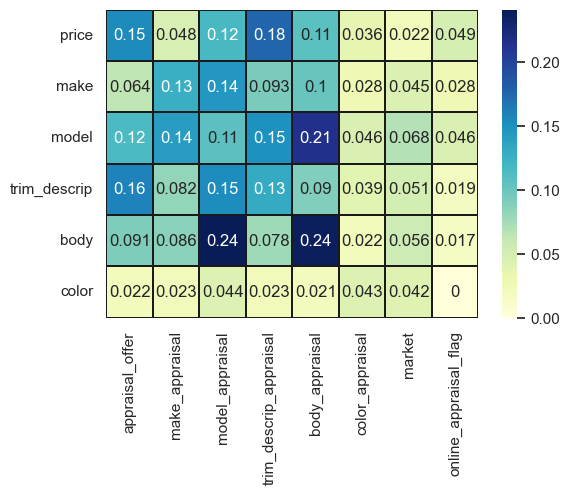

In [1792]:
cramerV_heatmap(df, appraisal_cols, purchase_cols)

**key takeaways**
- **market, online_appraisal_flag and color of the appraised car do not influence any feature of the purchased car**
- **price has a weak association with the trim description of the appraised car and appraisal_offer**
- make has a weak association with model and make of the appraised car
- **model has a moderate association with body of the appraised car**
- trim description has a weak association with appraisal_offer and model of appraised car
- **body has a moderate association with model and body of the appraised car**

## Price

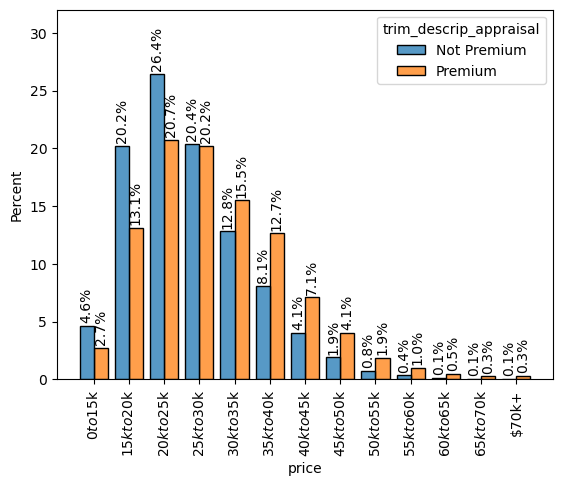

In [18]:
# trim_descrip_appraisal

df_copy = df.copy()
price_natsorted_idx = natsorted(df_copy['price'].value_counts().index)
df_copy['price'] = pd.Categorical(df_copy['price'], price_natsorted_idx)

g = sns.histplot(data = df_copy, x = 'price', hue='trim_descrip_appraisal', multiple = 'dodge',
                  stat = 'percent', shrink = 0.8, common_norm=False)

plt.ylim(0,32)

patches = g.axes.patches

for i in range(int(len(patches))):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()
    g.axes.annotate('{:.1f}%'.format(y), (x, y+0.5), ha='center', rotation=90)

plt.xticks(rotation=90)
plt.savefig('../plots/price_trim_description_appraisal.png', bbox_inches='tight')

The blue and orange histograms show the normalized price distribution of "Not Premium" and "Premium" appraisal cars. The percentages show the probability that a customer with a particular car trim description will buy a car in that price range. 

"Not Premium" Customers are most likely (26.4%) to buy a car in the 20k-25k price range. "Premium" customers are most likely (~40%) to buy a car in the price ranges 20k-30k.

"Not Premium" customers are 72% likely to buy a car in the price range < 25k-30k while "Premium" customers are only 56.7% likely to buy in the same price range. 

For price range > 25k-30k, "Premium" customers are 43.3% likely to purchase a car while "Not Premium" customers are only 27.9% likely.



In [20]:
# appraisal_offer

CrossResult = pd.crosstab(index=df['appraisal_offer'], 
                          columns=df['price'], 
                          normalize='index').round(4)*100

In [21]:
CrossResult = CrossResult.reindex(natsorted(CrossResult.index))

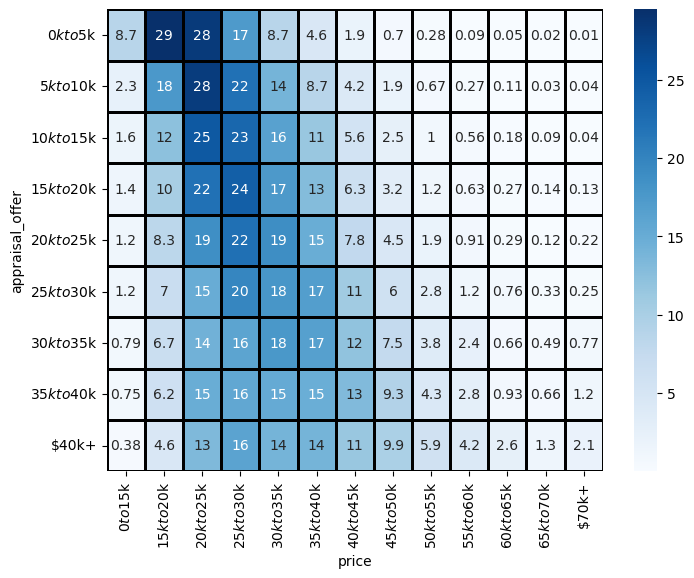

In [22]:
fig, ax = plt.subplots(figsize=(8,6))   
sns.heatmap(CrossResult, annot=True, ax=ax, linewidths=0.75, linecolor='k', cmap = 'Blues')
plt.yticks(rotation=0)
plt.savefig('../plots/price_appraisal_offer.png', bbox_inches='tight')

The numbers within the box represent the percentage of customers with a particular appraisal_offer (row) who purchased a car in a specific price range (column).

The general trend is as appraisal_offer increases, the price range within which customers are likely to buy a car increases. Also, the spread of the price range is narrow for lower appraisal_offers and broader for higher appraisal_offers.

## Make

In [1750]:
# make_appraisal
make_make_crosstab = pd.crosstab(index=df['make_appraisal'], 
            columns= df['make'],
            normalize='index').round(4)*100

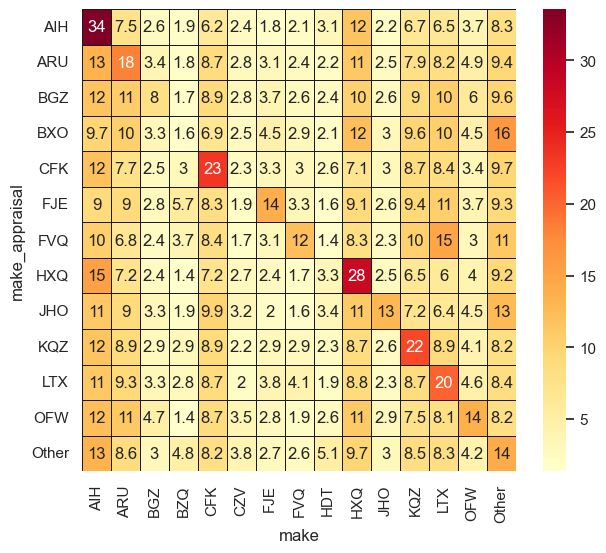

In [1753]:
fig, ax = plt.subplots(figsize=(7,6))   
sns.heatmap(make_make_crosstab, annot=True, ax=ax, linewidths=.5, linecolor='k',cmap='YlOrRd')
plt.savefig('../plots/make_make_heatmap.png', bbox_inches='tight')
plt.yticks(rotation=0);

**key takeaway**
- Customers who sell a car of a particular make are most likely to buy back a car with same make. This is true for 9/12 makes shown on the heatmap above
- Overall popular makes for customers to buy: AIH, ARU, CFK, HXQ, KQZ and LTX 

## Body

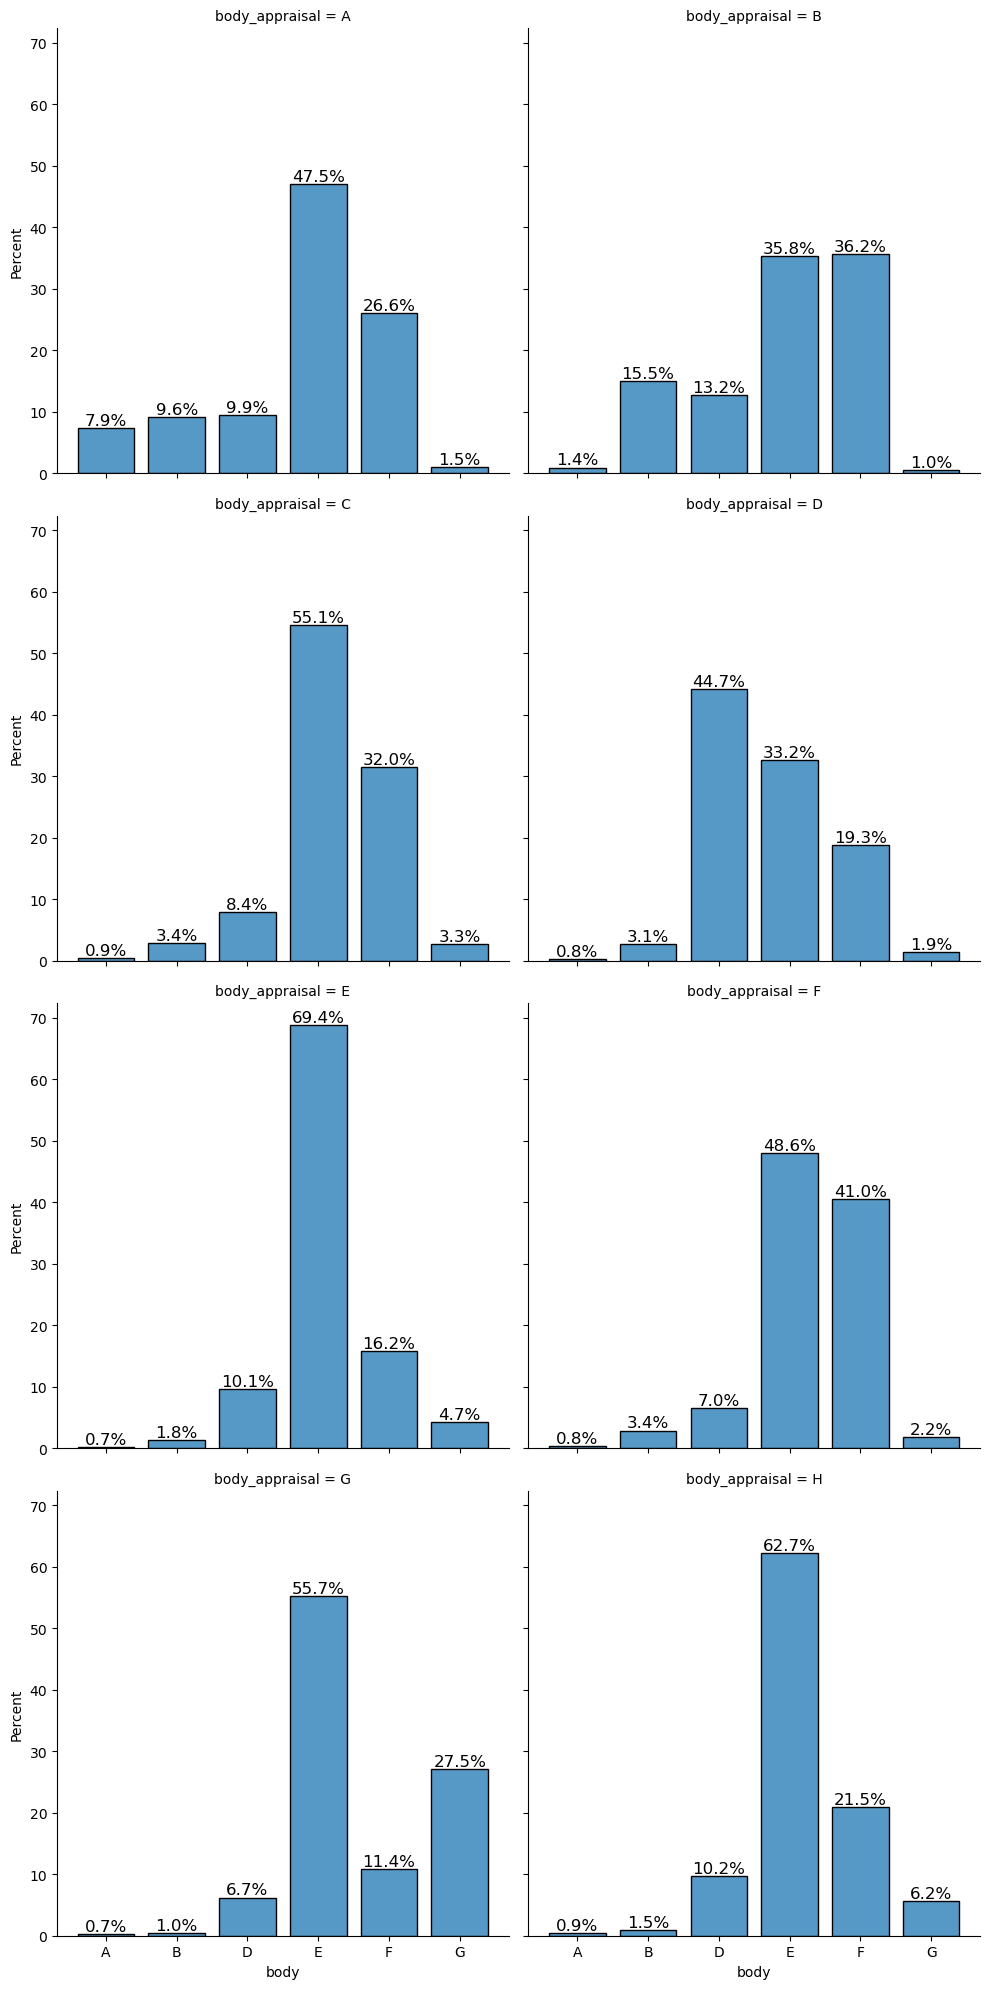

In [23]:
# body_appraisal

df_copy = df.copy()
df_copy['body'] = pd.Categorical(df_copy['body'],
                                   categories=['A','B','D','E','F','G'],
                                   ordered=True)

g = sns.displot(data = df_copy, x = 'body', col = 'body_appraisal', col_wrap = 2,
                col_order = ['A','B','C','D','E','F','G','H'],
                stat = 'percent', shrink = 0.8, common_norm=False, multiple = 'dodge')

axes = g.axes
for i in range(len(axes)):
    patches = axes[i].patches
    for j in range(len(patches)):
        x = patches[j].get_x() + patches[j].get_width()/2
        y = patches[j].get_height()+.5
        g.axes[i].annotate('{:.1f}%'.format(y), (x, y), ha='center', size =12)
        
plt.savefig('../plots/body_body_appraisal.png', bbox_inches='tight')

The top three body choices for customers who appraise a car with certain body type:

|Body Appraisal|Body_1|Body_2|Body_3|Total|
|---|---|---|---|---|
|A|E (47.5%)|F (26.6%)|D (9.9%)|84 %|
|B|E (35.8%)|F (36.2%)|B (15.5%)|87.5%|
|C|E (55.1%)|F (32%)|D (8.4%)|95.5%|
|D|D (44.7%)|E (33.2%)|F (19.3%)|97.2%|
|E|E (69.4%)|F (16.2%)|D (10.1%)|95.7%|
|F|E (48.6%)|F (41%)|D (7%)|96.6%|
|G|E (55.7%)|G (27.5%)|F (11.4%)|94.6%|
|H|E (62.7%)|F (21.5%)|D (10.2%)|94.4%|

For 6/8 body_appraisal types, the top 3 choices of body types are E, F and D. Except for body_appraisal types G and B. 

## Model

Since body_appraisal and body have a strong association, the model bought by a customer may be influenced by the body of the car.

So, my assumption is that the top models customers who sold a car of certain body type buy will be among the top models sold in the body types the customer is most likely to buy. 

In [26]:
# association between model and body of the purchased car
cramers_v_new(df['model'], df['body'])

(0.851625288264889, 0.0)

In [1754]:
# check if its possible to predict model from body_appraisal
def remove_items(given_list, item):
    
    res = [i for i in given_list if i != item]
 
    return res

def guess_popular_models(df, body_appraisal_type, body_purchase_type1, body_purchase_type2, 
                      body_purchase_type3=None):
    
    top10_models_by_body_appraisal = df[df['body_appraisal']==body_appraisal_type]['model'].\
value_counts()[:10].index.to_list()
    
    top_models_1 = df[df['body']== body_purchase_type1]['model'].value_counts().iloc[:10].\
    index.to_list()
    top_models_2 = df[df['body']== body_purchase_type2]['model'].value_counts().iloc[:10].\
    index.to_list()
    
    if body_purchase_type3:
        top_models_3 = df[df['body']== body_purchase_type3]['model'].value_counts().iloc[:10].\
    index.to_list()
        top_models_suggestion =  top_models_1 + top_models_2 + top_models_3
    else:
          top_models_suggestion = top_models_1 + top_models_2
        
    
    top10_models_by_body_appraisal = remove_items(top10_models_by_body_appraisal,'Other')
    top_models_bought = remove_items(top_models_suggestion, 'Other')

    
    s = 0    
    for i in top10_model_by_body_appraisal:
        if (i!='Other') & (i in top_models_bought):
            s+=1
        
    correct_guess_percent = round(s/len(top10_model_by_body_appraisal)*100,2)
    
    return correct_guess_percent
    

In [1763]:
guess_best_models(df,'E','E','F','D')

90.0

Using the top 10 models of the three body_types most likely to be bought by a customer contains 80-90% of the models typically bought by such a customer!

**Recommendation** : When a customer sells a car of 'X' body type, Carmax can suggest them the top 10 most bought car models in the body types likely to be bought by such a customer.


In [1003]:
# trim_descrip_appraisal

# top 10 models bought by customers who sold a premium car 
df[df['trim_descrip_appraisal']=='Premium'][['trim_descrip_appraisal',
                                             'model','trim_descrip']].value_counts()[:10]

trim_descrip_appraisal  model   trim_descrip
Premium                 CFK_8   Premium         933
                        CFK_5   Premium         855
                        HXQ_14  Premium         845
                        ARU_4   Not Premium     729
                        AIH_13  Not Premium     727
                        CFK_10  Premium         671
                        KQZ_3   Not Premium     660
                        HXQ_1   Premium         644
                        BZQ_4   Premium         641
                        HXQ_4   Premium         594
dtype: int64

In [1773]:
# top 10 premium car models 
df[df['trim_descrip']=='Premium']['model'].value_counts().iloc[:10]

Other     7367
HXQ_14    2586
CFK_8     2088
CFK_10    2016
CFK_5     1958
CZV_10    1831
HXQ_1     1506
HXQ_10    1405
BZQ_4     1351
HXQ_4     1305
Name: model, dtype: int64

7 out of 10 car models bought by a customer who sold a premium car are among the top 10 premium car models bought by all customers. The remaining 3 models are among the top 10 not premium models.

In the case of not premium cars, 9 out of 10 models are among the top 10 not premium car models bought by all customers. The remaining one is the top selling premium car model.

**Recommendation**: To a customer who sells a premium car (not-premium car) suggest top 10 premium (not premium) car models bought by all customers if no other information is available

## Trim_descrip

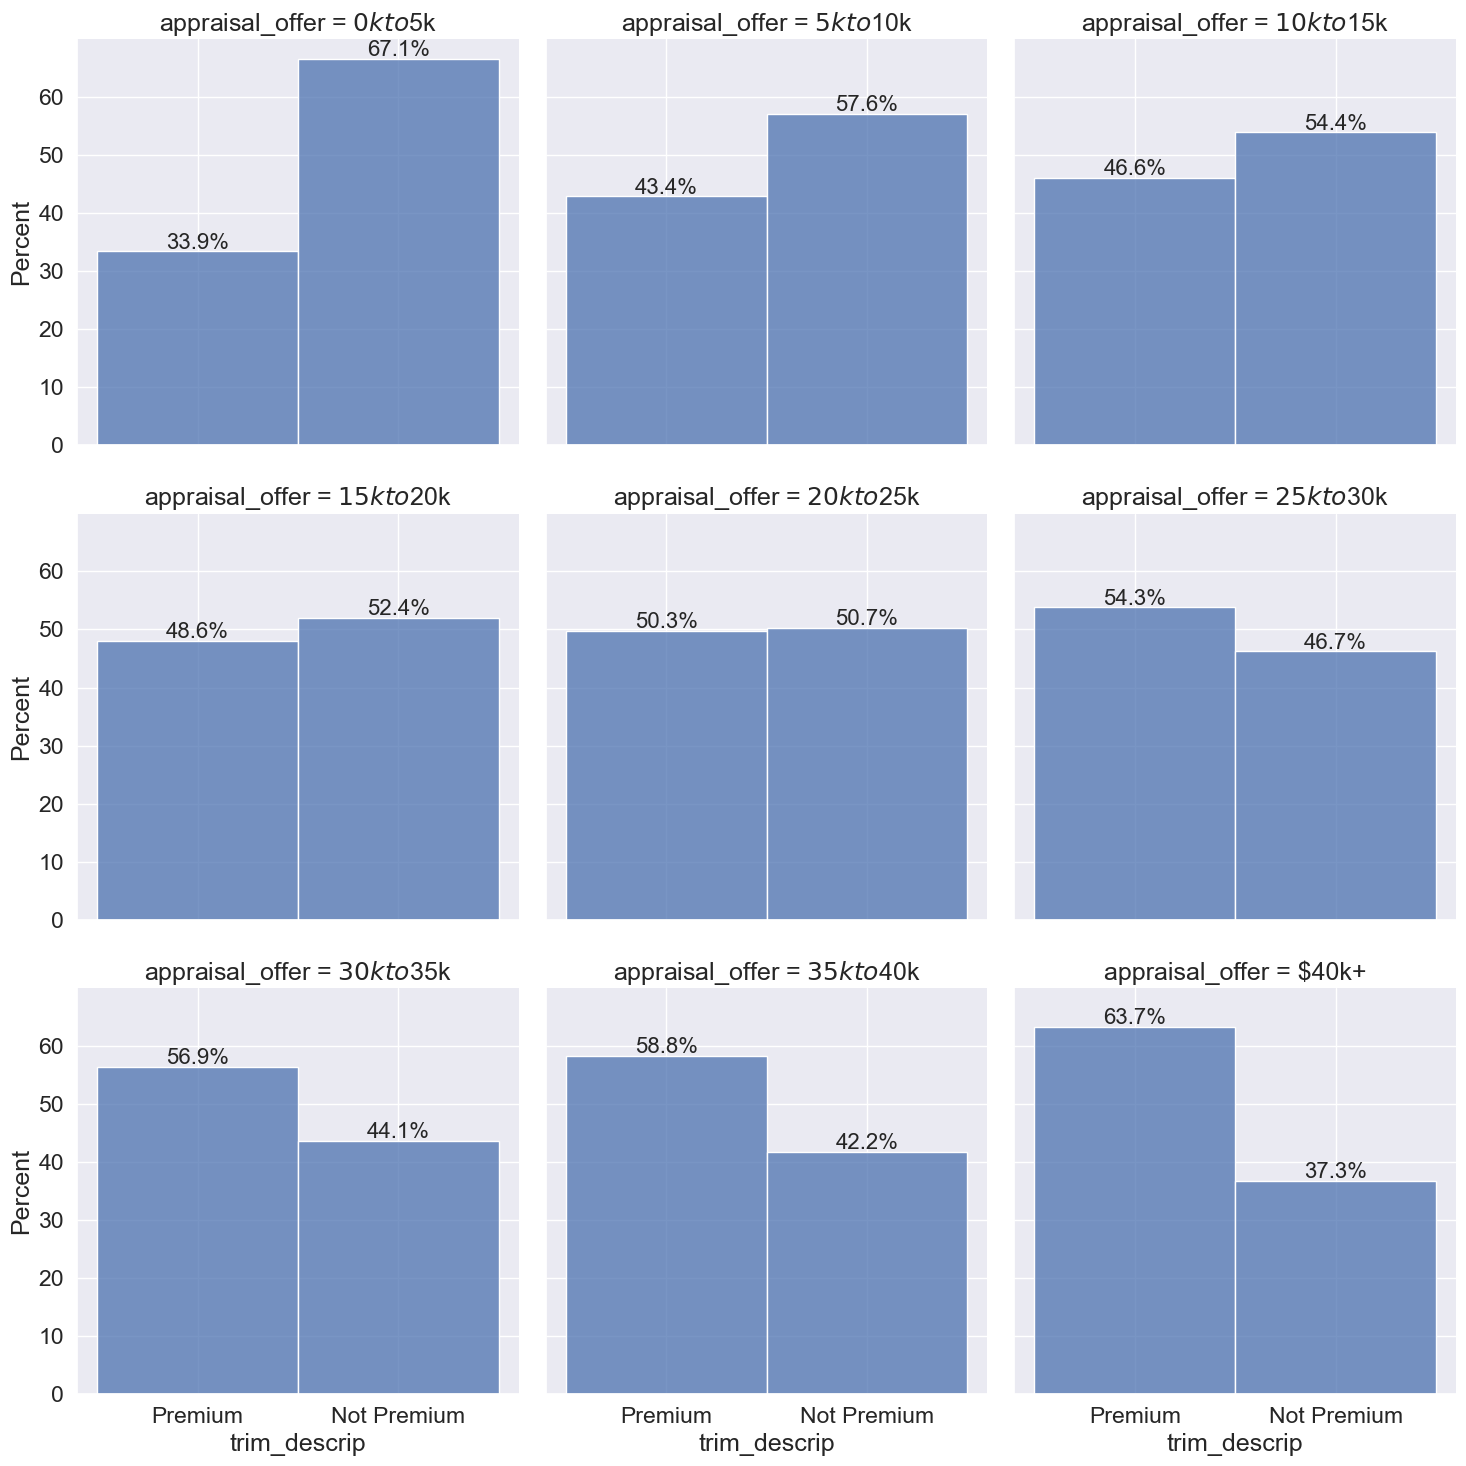

In [35]:
# appraisal_offer

sns.set(font_scale=1.5)
g = sns.displot(df, x='trim_descrip', col='appraisal_offer', 
                col_order = ['$0k to $5k','$5k to $10k','$10k to $15k','$15k to $20k',
                              '$20k to $25k','$25k to $30k','$30k to $35k','$35k to $40k','$40k+'],
                col_wrap=3, stat='percent', common_norm = False)

axes = g.axes
for i in range(len(axes)):
    patches = axes[i].patches
    for j in range(len(patches)):
        x = patches[j].get_x() + patches[j].get_width()/2
        y = patches[j].get_height()+.5
        g.axes[i].annotate('{:.1f}%'.format(y), (x, y), ha='center', size =16)
        
plt.savefig('../plots/trim_descrip_appraisal_offer.png',bbox_inches='tight')

Customers with appraisal_offer < 20k-25k are more likely to purchase a not premium car while customers with appraisal_offer > 20k-25k are more likely to buy a premium car.

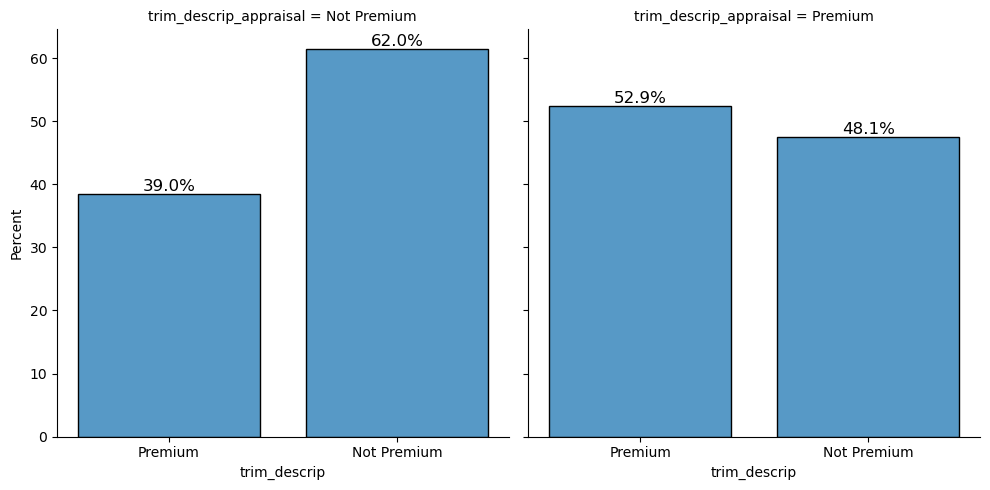

In [1089]:
# trim_descrip_appraisal

g = sns.displot(data= df, x='trim_descrip',
            col='trim_descrip_appraisal', col_wrap= 2, stat='percent', common_norm=False, shrink=0.8);

axes = g.axes
for i in range(len(axes)):
    patches = axes[i].patches
    for j in range(len(patches)):
        x = patches[j].get_x() + patches[j].get_width()/2
        y = patches[j].get_height()+.5
        g.axes[i].annotate('{:.1f}%'.format(y), (x, y), ha='center', size =12)

Customers who sold a not-premium car are 62% likely to buy a not premium car. While customers who sold a premium car are almost equally likely to purchase a premium or not premium car. 

For example, let me choose a customer who sold a car with body type B.

For example, let me choose a customer who sold a car with body type B.

In [120]:
# The top 10 models bought by customers with body_appraisal B

body_appraisal_B = df[df['body_appraisal']=='B']

In [121]:
Counter(body_appraisal_B['model']).most_common(10)

[('HXQ_8', 228),
 ('HXQ_14', 193),
 ('FJE_5', 190),
 ('KQZ_11', 181),
 ('LTX_21', 178),
 ('BZQ_4', 131),
 ('FJE_10', 130),
 ('AIH_13', 117),
 ('CFK_8', 116),
 ('AIH_25', 94)]

Let me suggest the top 4 models from body type E and F. Top model from body type B and D.

In [122]:
Counter(df[df['body']=='E']['model']).most_common(4)

[('ARU_4', 3941), ('CFK_8', 3557), ('HXQ_10', 3246), ('AIH_5', 3133)]

In [123]:
Counter(df[df['body']=='F']['model']).most_common(4)

[('AIH_13', 3857), ('HXQ_14', 3492), ('HXQ_8', 2953), ('AIH_25', 2677)]

In [127]:
Counter(df[df['body']=='B']['model']).most_common(1)

[('FJE_5', 971)]

In [125]:
Counter(df[df['body']=='D']['model']).most_common(1)

[('BZQ_4', 3086)]

## Model_year

In [1793]:
# model_year_appraisal

df['binned_model_year_appraisal'] = pd.cut(df['model_year_appraisal'], bins = [1980, 1990, 1995, 2000, 2005, 2010, 2015, 2020],
       labels = ['< 1990', '1990 to 1995', '1995 to 2000', '2000 to 2005', '2005 to 2010',
                 '2010 to 2015', '2015 <'])

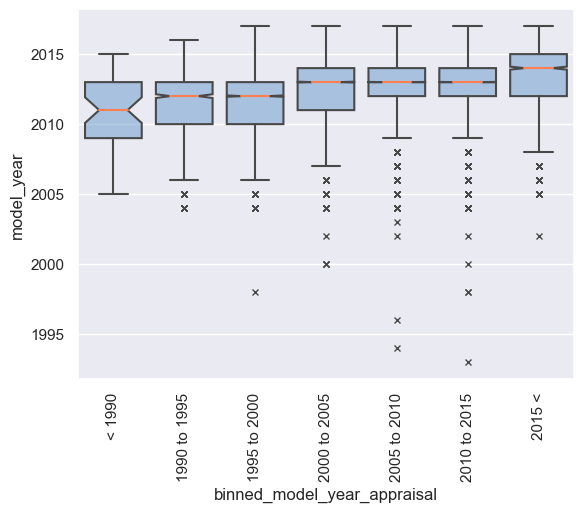

In [1809]:
sns.boxplot(data=df, x = 'binned_model_year_appraisal', y = 'model_year',
            notch=True, showcaps=True, flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": 'co'})
plt.xticks(rotation=90);

In [1826]:
# variance 
bin_labels = ['< 1990', '1990 to 1995', '1995 to 2000', '2000 to 2005', '2005 to 2010',
                 '2010 to 2015', '2015 <']
for item in bin_labels:
    print(f'bin: {item}')
    var = np.var(df.loc[df['binned_model_year_appraisal']==item,'model_year'])
    print(f'{var:.2f}')

bin: < 1990
7.20
bin: 1990 to 1995
6.36
bin: 1995 to 2000
5.91
bin: 2000 to 2005
4.65
bin: 2005 to 2010
3.83
bin: 2010 to 2015
3.62
bin: 2015 <
4.51


In [1836]:
ttest_ind(df.loc[df['binned_model_year_appraisal']=='2005 to 2010', 'model_year'],
         df.loc[df['binned_model_year_appraisal']=='2010 to 2015', 'model_year'], 
         equal_var=True, alternative='two-sided')

Ttest_indResult(statistic=-24.668902277710632, pvalue=6.226148076355499e-134)

## What does model_year_appraisal tell about trim_descrip?

In [311]:
df['model_year_appraisal'] = df['model_year_appraisal'].astype(int)

/var/folders/j7/hwph9dvj1x7frlns2v49lv6r0000gn/T/ipykernel_86255/2781694832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_year_appraisal'] = df['model_year_appraisal'].astype(int)


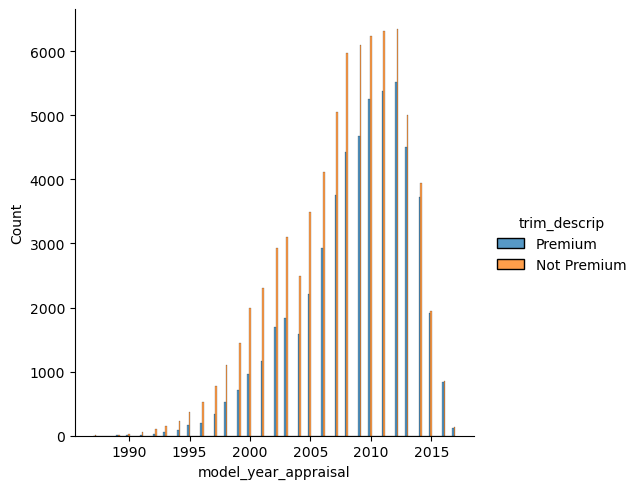

In [ ]:
sns.displot(df, x='model_year_appraisal',hue='trim_descrip', 
            multiple='dodge', height = 5, aspect=1, stat='count', common_norm=True);

For all model_year_appraisals older than 2015, customers are more likely to buy a not-premium car. However, the tendency to buy a premium car increases after model_appraisal_years 2008/2009.

In [ ]:
df['binned_model_year_appraisal'] = pd.cut(df['model_year_appraisal'], bins = [1980, 1990, 1995, 2000, 2005, 2010, 2015, 2020],
       labels = ['< 1990', '1990 to 1995', '1995 to 2000', '2000 to 2005', '2005 to 2010',
                 '2010 to 2015', '2015 <'])

/var/folders/j7/hwph9dvj1x7frlns2v49lv6r0000gn/T/ipykernel_86255/390352344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binned_model_year_appraisal'] = pd.cut(df['model_year_appraisal'], bins = [1980, 1990, 1995, 2000, 2005, 2010, 2015, 2020],


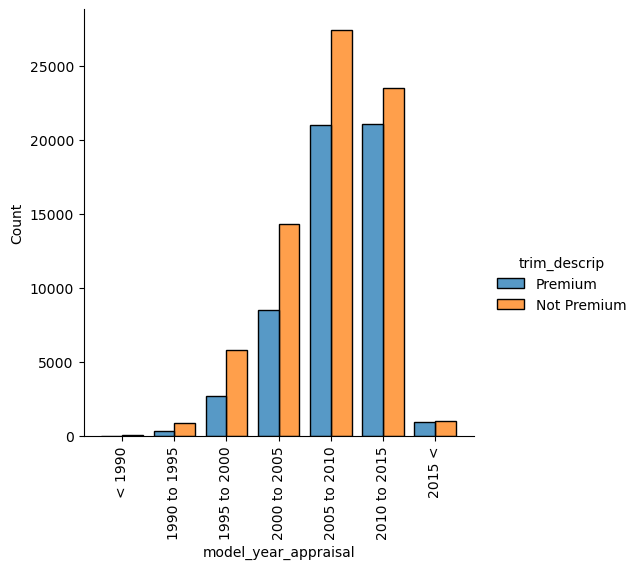

In [ ]:
sns.displot(df, x='binned_model_year_appraisal',hue='trim_descrip', 
            multiple='dodge', shrink = 0.8, height = 5, aspect=1, 
            stat='count', common_norm=False)
plt.xlabel('model_year_appraisal')
plt.xticks(rotation=90);